In [1]:
import matplotlib
matplotlib.use('Agg')

import collections
import numpy as np
import os
import h5py
from scipy.stats import zscore
import pyret.filtertools as ft
import pyret.spiketools as sp
import pyret.stimulustools as st
from deepretina.toolbox import load_model, load_partial_model, rolling_window
from deepretina.io import despine
from deepretina.metrics import cc
from scipy.interpolate import interp1d
from scipy.signal import detrend

from tqdm import tqdm

%matplotlib inline
from matplotlib.pyplot import *
import matplotlib.pyplot as plt

plt.style.use('deepretina')

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'seismic'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using gpu device 0: GeForce GT 750M (CNMeM is disabled)
Using Theano backend.


You must install GPy (pip install GPy) to fit the GP regression nonlinearity.


In [2]:
data_dir = os.path.expanduser('~/data/kastner/')
horizontals = [x[0] for x in os.walk(data_dir + 'horizontal')]
amacrines = [x[0] for x in os.walk(data_dir + 'amacrine')]
bipolars = [x[0] for x in os.walk(data_dir + 'bipolar') if 'reproduce' not in x[0]]

### Take shortest amount of data so you can store all interneurons as an array with the same time

In [7]:
minimum_times = {}
all_times = collections.defaultdict(list)
for idh,h_file in enumerate(amacrines):
    try:
        with open(h_file + '/' + 'README.txt', 'r') as f:
            text = f.read()
            lines = text.split('\n')
            for l in lines:
                params = l.split(', ')
                if params[0] in ['boxes', 'flash', 'flashStim', 'flash_v',
                                 'intraRF', 'intraRF_v', 'lines', 'linesRF_v']:
                    all_times[params[0]].append(float(params[-1]))

    except Exception as e:
        print(e, h_file)
        
for key in all_times.keys():
    minimum_times[key] = np.min(all_times[key])

[Errno 2] No such file or directory: '/Users/lmcintosh/data/kastner/amacrine/2011/README.txt' /Users/lmcintosh/data/kastner/amacrine/2011
[Errno 2] No such file or directory: '/Users/lmcintosh/data/kastner/amacrine/2012/README.txt' /Users/lmcintosh/data/kastner/amacrine/2012


In [8]:
minimum_times

{'boxes': 500.01499999999999,
 'flash': 2.0005000000000002,
 'flashStim': 22.0,
 'flash_v': 22.0,
 'intraRF': 0.5,
 'intraRF_v': 100.001,
 'lines': 300.02699999999999,
 'linesRF_v': 200.0}

# Interpolate/truncate the stimuli

In [11]:
sampling_rate = 0.01

In [12]:
stimulus_times = {
    'boxes': collections.defaultdict(list),
    'flashStim': collections.defaultdict(list),
    'lines': collections.defaultdict(list)
    }
truncated_stim_times = {
    'boxes': collections.defaultdict(list),
    'flashStim': collections.defaultdict(list),
    'lines': collections.defaultdict(list)
    }

for idh,h_file in tqdm(enumerate(amacrines)):
    if h_file not in ['/Users/lmcintosh/data/kastner/amacrine',
                      '/Users/lmcintosh/data/kastner/amacrine/2011',
                      '/Users/lmcintosh/data/kastner/amacrine/2012']:
        h_id = h_file.split('/')[-1]
        
        # stimuli
        boxes = np.loadtxt(h_file + '/boxes.txt', skiprows=1)
        lines = np.loadtxt(h_file + '/lines.txt', skiprows=1)
        flashStim = np.loadtxt(h_file + '/flashStim.txt', skiprows=1)
        
        # reshape stimuli
        boxes = boxes.reshape((-1, 38, 38))
        lines = lines.reshape((-1, 100))
        
        # read README to get times
        times = collections.defaultdict(list)
        with open(h_file + '/README.txt', 'r') as f:
            text = f.read()
            readme_lines = text.split('\n')
            for l in readme_lines:
                params = l.split(', ')
                if params[0] in ['flashStim', 'boxes', 'lines']:
                    times[params[0]] = np.linspace(float(params[-2]), float(params[-1]), len(eval(params[0])))
                    scaling_factor = np.mean(np.diff(times[params[0]]))/sampling_rate
                    if scaling_factor > 1:
                        print('%s in %s is going to be upsampled by %f' %(params[0], h_id, scaling_factor))
                        stim_us, time_us = st.upsample_stim(eval(params[0]), int(scaling_factor), times[params[0]])
                    else:
                        print('%s in %s is going to be downsampled by %f' %(params[0], h_id, 1./scaling_factor))
                        stim_us, time_us = st.downsample_stim(eval(params[0]), int(1./scaling_factor), times[params[0]])

                    stimulus_times[params[0]][h_id].append(time_us)
                    if params[0] in ['flashStim']:
                        idx = np.argmin(abs(minimum_times['flash_v'] - time_us))
                        truncated_stim_times['flashStim'][h_id].append(time_us[:idx])
                    elif params[0] in ['boxes']:
                        idx = np.argmin(abs(minimum_times['intraRF_v'] - time_us))
                        truncated_stim_times['boxes'][h_id].append(time_us[:idx])
                    elif params[0] in ['lines']:
                        idx = np.argmin(abs(minimum_times['linesRF_v'] - time_us))
                        truncated_stim_times['lines'][h_id].append(time_us[:idx])

0it [00:00, ?it/s]

boxes in 110611_c3 is going to be upsampled by 3.334796
lines in 110611_c3 is going to be upsampled by 3.334978
flashStim in 110611_c3 is going to be downsampled by 99.999545

3it [00:31, 10.56s/it]


boxes in 010412_c1 is going to be upsampled by 3.334796
lines in 010412_c1 is going to be upsampled by 3.334978

5it [01:03, 12.15s/it]


flashStim in 010412_c1 is going to be downsampled by 99.999545
boxes in 010912_c2 is going to be upsampled by 3.334796
lines in 010912_c2 is going to be upsampled by 3.334978
flashStim in 010912_c2 is going to be downsampled by 99.999545

6it [01:35, 18.02s/it]


boxes in 011612_c1 is going to be upsampled by 3.334796
lines in 011612_c1 is going to be upsampled by 3.334978

7it [02:06, 22.03s/it]


flashStim in 011612_c1 is going to be downsampled by 99.999545
boxes in 011912_c6 is going to be upsampled by 3.334796
lines in 011912_c6 is going to be upsampled by 3.334978
flashStim in 011912_c6 is going to be downsampled by 99.999545

8it [02:38, 24.93s/it]


boxes in 040412_c1 is going to be upsampled by 3.001651
lines in 040412_c1 is going to be upsampled by 3.001771
flashStim in 040412_c1 is going to be downsampled by 99.999545

9it [03:08, 26.62s/it]


boxes in 040512_c2 is going to be upsampled by 3.001651
lines in 040512_c2 is going to be upsampled by 3.001771

10it [03:41, 28.59s/it]


flashStim in 040512_c2 is going to be downsampled by 99.999545


KeyboardInterrupt: 

In [13]:
for expt in truncated_stim_times['boxes'].keys():
    print(truncated_stim_times['boxes'][expt][0][-1], len(truncated_stim_times['boxes'][expt][0]), expt)

99.9883113877 8996 110611_c3
99.9949955977 9995 040512_c2
99.9949955977 9995 040412_c1
99.9883113877 8996 010912_c2
99.9883113877 8996 010412_c1
99.9883113877 8996 011912_c6
99.9883113877 8996 011612_c1


## Since David made all the stimuli the same, just save one of them

In [14]:
expt = '040412_c1'
stimuli = {}
stimuli_time = {}

for idh,h_file in enumerate(amacrines):
    h_id = h_file.split('/')[-1]
    if h_id == expt:
        # stimuli
        boxes = np.loadtxt(h_file + '/boxes.txt', skiprows=1)
        lines = np.loadtxt(h_file + '/lines.txt', skiprows=1)
        flashStim = np.loadtxt(h_file + '/flashStim.txt', skiprows=1)
        
        # reshape stimuli
        boxes = boxes.reshape((-1, 38, 38))
        lines = lines.reshape((-1, 100))
        
        # read README to get times
        times = collections.defaultdict(list)
        with open(h_file + '/README.txt', 'r') as f:
            text = f.read()
            readme_lines = text.split('\n')
            for l in readme_lines:
                params = l.split(', ')
                if params[0] in ['flashStim', 'boxes', 'lines']:
                    times[params[0]] = np.linspace(float(params[-2]), float(params[-1]), len(eval(params[0])))
                    scaling_factor = np.mean(np.diff(times[params[0]]))/sampling_rate
                    if scaling_factor > 1:
                        print('%s in %s is going to be upsampled by %f' %(params[0], h_id, scaling_factor))
                        stim_us, time_us = st.upsample_stim(eval(params[0]), int(scaling_factor), times[params[0]])
                    else:
                        print('%s in %s is going to be downsampled by %f' %(params[0], h_id, 1./scaling_factor))
                        stim_us, time_us = st.downsample_stim(eval(params[0]), int(1./scaling_factor), times[params[0]])

                    if params[0] in ['flashStim']:
                        idx = np.argmin(abs(minimum_times['flash_v'] - time_us))
                        stimuli_time['flashStim'] = time_us[:idx]
                        stimuli['flashStim'] = stim_us[:idx]
                    elif params[0] in ['boxes']:
                        idx = np.argmin(abs(minimum_times['intraRF_v'] - time_us))
                        stimuli_time['boxes'] = time_us[:idx]
                        stimuli['boxes'] = stim_us[:idx]
                    elif params[0] in ['lines']:
                        idx = np.argmin(abs(minimum_times['linesRF_v'] - time_us))
                        stimuli_time['lines'] = time_us[:idx]
                        stimuli['lines'] = stim_us[:idx]

boxes in 040412_c1 is going to be upsampled by 3.001651
lines in 040412_c1 is going to be upsampled by 3.001771
flashStim in 040412_c1 is going to be downsampled by 99.999545


In [15]:
stimuli['boxes'].shape

(9995, 38, 38)

In [16]:
stimuli_time['boxes'].shape

(9995,)

In [17]:
stimuli['lines'].shape

(19988, 100)

In [18]:
stimuli_time['lines'].shape

(19988,)

In [19]:
stimuli['flashStim'].shape

(2222,)

In [20]:
stimuli_time['flashStim'].shape

(2222,)

# Go back and re-save all membrane potentials but with new target time

In [22]:
target_times = {}
for key in minimum_times.keys():
    if key == 'intraRF_v':
        target_times[key] = stimuli_time['boxes']
    elif key == 'linesRF_v':
        target_times[key] = stimuli_time['lines']
    elif key == 'flash_v':
        target_times[key] = stimuli_time['flashStim']
        
receptive_fields = {
    'intraRF': collections.defaultdict(list),
    'linesRF': collections.defaultdict(list),
    'flash': collections.defaultdict(list)
    }

membrane_potentials = {
    'intraRF_v': collections.defaultdict(list),
    'linesRF_v': collections.defaultdict(list),
    'flash_v': collections.defaultdict(list)
}

detrended_membrane_potentials = {
    'intraRF_v': collections.defaultdict(list),
    'linesRF_v': collections.defaultdict(list),
    'flash_v': collections.defaultdict(list)
}
smoothing_step = int(2/.001) # 2 second smoothing filter

for idh,h_file in tqdm(enumerate(amacrines)):
    if h_file not in ['/Users/lmcintosh/data/kastner/amacrine',
                      '/Users/lmcintosh/data/kastner/amacrine/2011',
                      '/Users/lmcintosh/data/kastner/amacrine/2012']:
        h_id = h_file.split('/')[-1]
        
        # receptive fields
        intraRF = np.loadtxt(h_file + '/intraRF.txt', skiprows=1)
        linesRF = np.loadtxt(h_file + '/linesRF.txt', skiprows=1)
        flash = np.loadtxt(h_file + '/flash.txt', skiprows=1)
        
        # membrane potential
        intraRF_v = np.loadtxt(h_file + '/intraRF_v.txt', skiprows=1)
        linesRF_v = np.loadtxt(h_file + '/linesRF_v.txt', skiprows=1)
        flash_v = np.loadtxt(h_file + '/flash_v.txt', skiprows=1)
        
        # reshape relevant variables
        intraRF = intraRF.reshape((-1, 38, 38))
        linesRF = linesRF.reshape((-1, 100))
        
        # save RFs
        receptive_fields['intraRF'][h_id] = intraRF
        receptive_fields['linesRF'][h_id] = linesRF
        receptive_fields['flash'][h_id] = flash
        
        # read README to get times
        times = collections.defaultdict(list)
        with open(h_file + '/README.txt', 'r') as f:
            text = f.read()
            lines = text.split('\n')
            for l in lines:
                params = l.split(', ')
                if params[0] in ['flash', 'flash_v', 'intraRF', 'intraRF_v', 'linesRF_v']:
                    times[params[0]] = np.linspace(float(params[1]), float(params[2]), len(eval(params[0])))
        
        # interpolate membrane potentials
        for key in ['flash_v', 'intraRF_v', 'linesRF_v']:
            mem_pot_interp = interp1d(times[key], eval(key), kind='linear', bounds_error=False,
                                     fill_value='extrapolate')
            membrane_potentials[key][h_id] = mem_pot_interp(target_times[key])
            
            # detrend
            detrended_mem_pot = detrend(eval(key), type='linear', bp=np.arange(smoothing_step, 
                                                                               len(eval(key))-smoothing_step,
                                                                               smoothing_step))
            
            detrended_interp = interp1d(times[key], detrended_mem_pot, kind='linear', bounds_error=False,
                                       fill_value='extrapolate')
            detrended_membrane_potentials[key][h_id] = detrended_interp(target_times[key])


0it [00:00, ?it/s]/usr/local/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


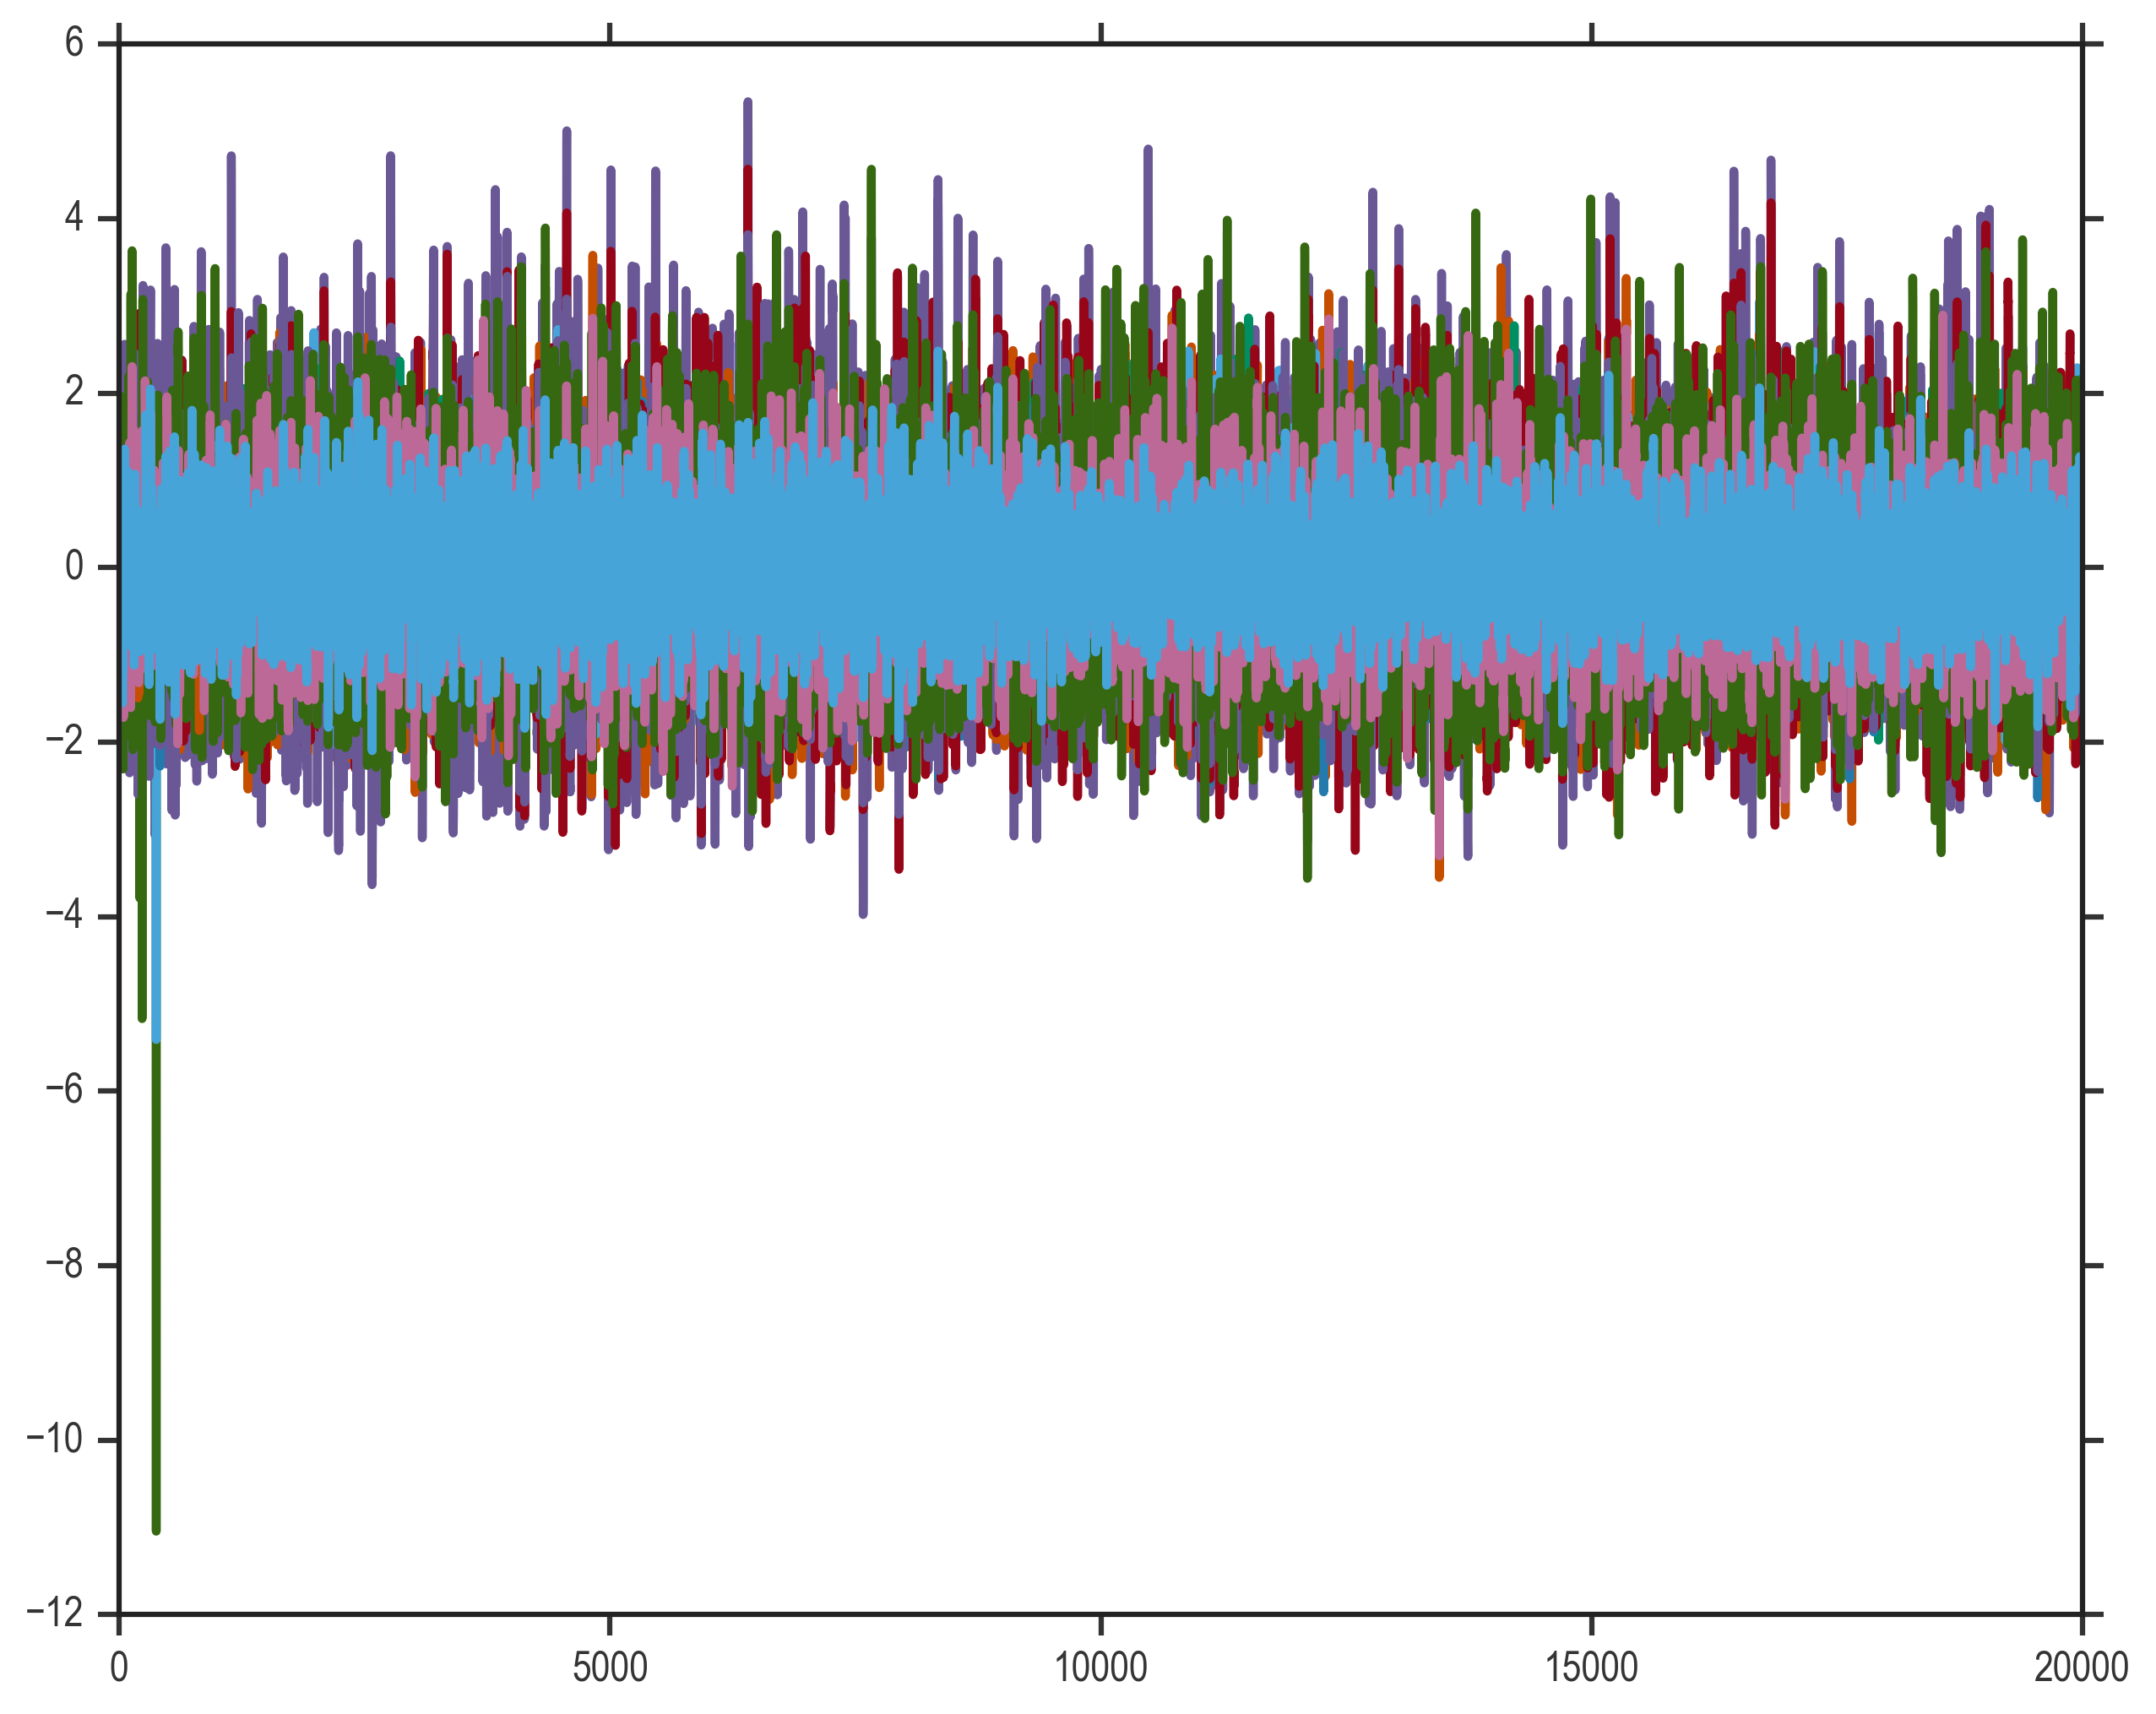

In [23]:
for expt in detrended_membrane_potentials['linesRF_v']:
    plt.plot(detrended_membrane_potentials['linesRF_v'][expt])
# xlim(200,220)

In [24]:
np.stack([detrended_membrane_potentials['linesRF_v'][key] for key in detrended_membrane_potentials['linesRF_v']]).shape

(27, 19988)

## Save h5 file

In [25]:
sorted_expts = sorted([key for key in detrended_membrane_potentials['intraRF_v']])

In [26]:
sorted_expts

['010412_c1',
 '010912_c2',
 '011612_c1',
 '011912_c6',
 '040412_c1',
 '040512_c2',
 '062612_c2',
 '090312_r2_c1',
 '091612_r2_c1',
 '092312_r2_c1',
 '110412_c2',
 '110611_c3',
 '111112_r1_c1',
 '111112_r2_c1',
 '112512_c2',
 '120212_r1_c3',
 '120212_r2_c2',
 '121612_r1_c2',
 '121812_r1_c1',
 '122012_c1',
 '122012_c2',
 '122112_c1',
 '122512_r1_c2',
 '122512_r2_c2',
 '122812_r2_c1',
 '123012_c1',
 '123112_r1_c1']

In [28]:
[len(s) for s in sorted_expts]

[9,
 9,
 9,
 9,
 9,
 9,
 9,
 12,
 12,
 12,
 9,
 9,
 12,
 12,
 9,
 12,
 12,
 12,
 12,
 9,
 9,
 9,
 12,
 12,
 12,
 9,
 12]

In [29]:
with h5py.File('amacrines.h5', 'w') as g:
    # expts
    ascii_expts = [n.encode("ascii", "ignore") for n in sorted_expts]
    g.create_dataset('expts', (len(ascii_expts),1), 'S12', ascii_expts)
    
    # stimuli
    g.create_dataset('lines/stimuli', data=stimuli['lines'])
    g.create_dataset('boxes/stimuli', data=stimuli['boxes'])
    g.create_dataset('flashes/stimuli', data=stimuli['flashStim'])
    
    # time
    g.create_dataset('lines/time', data=stimuli_time['lines'])
    g.create_dataset('boxes/time', data=stimuli_time['boxes'])
    g.create_dataset('flashes/time', data=stimuli_time['flashStim'])
    
    # receptive fields
    for expt in sorted_expts:
        g.create_dataset('lines/rfs/%s' %expt, data=receptive_fields['linesRF'][expt])
        g.create_dataset('boxes/rfs/%s' %expt, data=receptive_fields['intraRF'][expt])
        g.create_dataset('flashes/rfs/%s' %expt, data=receptive_fields['flash'][expt])
        
    # membrane potentials
    g.create_dataset('lines/membrane_potential',
                    data=np.stack(membrane_potentials['linesRF_v'][key] for key in sorted_expts))
    g.create_dataset('boxes/membrane_potential',
                data=np.stack(membrane_potentials['intraRF_v'][key] for key in sorted_expts))
    g.create_dataset('flashes/membrane_potential',
                data=np.stack(membrane_potentials['flash_v'][key] for key in sorted_expts))
    
    # detrended membrane potentials
    g.create_dataset('lines/detrended_membrane_potential',
                    data=np.stack(detrended_membrane_potentials['linesRF_v'][key] for key in sorted_expts))
    g.create_dataset('boxes/detrended_membrane_potential',
                data=np.stack(detrended_membrane_potentials['intraRF_v'][key] for key in sorted_expts))
    g.create_dataset('flashes/detrended_membrane_potential',
                data=np.stack(detrended_membrane_potentials['flash_v'][key] for key in sorted_expts))

# Different experiments between early 2012 and late 2012

In [32]:
expt = '010412_c1'
early_stimuli = {}
early_stimuli_time = {}

for idh,a_file in enumerate(amacrines):
    a_id = a_file.split('/')[-1]
    if a_id == expt:
        # stimuli
        boxes = np.loadtxt(a_file + '/boxes.txt', skiprows=1)
        lines = np.loadtxt(a_file + '/lines.txt', skiprows=1)
        flashStim = np.loadtxt(a_file + '/flashStim.txt', skiprows=1)
        
        # reshape stimuli
        boxes = boxes.reshape((-1, 38, 38))
        lines = lines.reshape((-1, 100))
        
        # read README to get times
        times = collections.defaultdict(list)
        with open(a_file + '/README.txt', 'r') as f:
            text = f.read()
            readme_lines = text.split('\n')
            for l in readme_lines:
                params = l.split(', ')
                if params[0] in ['flashStim', 'boxes', 'lines']:
                    times[params[0]] = np.linspace(float(params[-2]), float(params[-1]), len(eval(params[0])))
                    scaling_factor = np.mean(np.diff(times[params[0]]))/sampling_rate
                    if scaling_factor > 1:
                        print('%s in %s is going to be upsampled by %f' %(params[0], a_id, scaling_factor))
                        stim_us, time_us = st.upsample_stim(eval(params[0]), int(scaling_factor), times[params[0]])
                    else:
                        print('%s in %s is going to be downsampled by %f' %(params[0], a_id, 1./scaling_factor))
                        stim_us, time_us = st.downsample_stim(eval(params[0]), int(1./scaling_factor), times[params[0]])

                    if params[0] in ['flashStim']:
                        idx = np.argmin(abs(minimum_times['flash_v'] - time_us))
                        early_stimuli_time['flashStim'] = time_us[:idx]
                        early_stimuli['flashStim'] = stim_us[:idx]
                    elif params[0] in ['boxes']:
                        idx = np.argmin(abs(minimum_times['intraRF_v'] - time_us))
                        early_stimuli_time['boxes'] = time_us[:idx]
                        early_stimuli['boxes'] = stim_us[:idx]
                    elif params[0] in ['lines']:
                        idx = np.argmin(abs(minimum_times['linesRF_v'] - time_us))
                        early_stimuli_time['lines'] = time_us[:idx]
                        early_stimuli['lines'] = stim_us[:idx]

boxes in 010412_c1 is going to be upsampled by 3.334796
lines in 010412_c1 is going to be upsampled by 3.334978
flashStim in 010412_c1 is going to be downsampled by 99.999545


In [33]:
stimuli['lines'].shape

(19988, 100)

In [34]:
early_stimuli['lines'].shape

(17991, 100)

In [41]:
early_sorted_expts = [expt for expt in sorted_expts if (float(expt[:2]) < 4) or (expt[4:6] == '11')]

In [42]:
early_sorted_expts

['010412_c1', '010912_c2', '011612_c1', '011912_c6', '110611_c3']

In [43]:
late_sorted_expts = [expt for expt in sorted_expts if expt not in early_sorted_expts]

# late experiments

In [45]:
late_2012_expts = late_sorted_expts
with h5py.File('amacrines_late_2012.h5', 'w') as g:
    # expts
    ascii_expts = [n.encode("ascii", "ignore") for n in late_2012_expts]
    g.create_dataset('expts', (len(ascii_expts),1), 'S12', ascii_expts)
    
    # stimuli
    g.create_dataset('lines/stimuli', data=stimuli['lines'])
    g.create_dataset('boxes/stimuli', data=stimuli['boxes'])
    g.create_dataset('flashes/stimuli', data=stimuli['flashStim'])
    
    # time
    g.create_dataset('lines/time', data=stimuli_time['lines'])
    g.create_dataset('boxes/time', data=stimuli_time['boxes'])
    g.create_dataset('flashes/time', data=stimuli_time['flashStim'])
    
    # receptive fields
    for expt in late_2012_expts:
        g.create_dataset('lines/rfs/%s' %expt, data=receptive_fields['linesRF'][expt])
        g.create_dataset('boxes/rfs/%s' %expt, data=receptive_fields['intraRF'][expt])
        g.create_dataset('flashes/rfs/%s' %expt, data=receptive_fields['flash'][expt])
        
    # membrane potentials
    g.create_dataset('lines/membrane_potential',
                    data=np.stack(membrane_potentials['linesRF_v'][key] for key in late_2012_expts))
    g.create_dataset('boxes/membrane_potential',
                data=np.stack(membrane_potentials['intraRF_v'][key] for key in late_2012_expts))
    g.create_dataset('flashes/membrane_potential',
                data=np.stack(membrane_potentials['flash_v'][key] for key in late_2012_expts))
    
    # detrended membrane potentials
    g.create_dataset('lines/detrended_membrane_potential',
                    data=np.stack(detrended_membrane_potentials['linesRF_v'][key] for key in late_2012_expts))
    g.create_dataset('boxes/detrended_membrane_potential',
                data=np.stack(detrended_membrane_potentials['intraRF_v'][key] for key in late_2012_expts))
    g.create_dataset('flashes/detrended_membrane_potential',
                data=np.stack(detrended_membrane_potentials['flash_v'][key] for key in late_2012_expts))

# early experiments

In [46]:
early_2012_expts = early_sorted_expts

In [48]:
sampling_rate = 0.01
early_target_times = {}
for key in minimum_times.keys():
    if key == 'intraRF_v':
        early_target_times[key] = early_stimuli_time['boxes']
    elif key == 'linesRF_v':
        early_target_times[key] = early_stimuli_time['lines']
    elif key == 'flash_v':
        early_target_times[key] = early_stimuli_time['flashStim']
        
smoothing_step = int(2/.001) # 2 second smoothing filter

for idh,h_file in tqdm(enumerate(amacrines)):
    h_id = h_file.split('/')[-1]
    if h_id in early_2012_expts:
        
        # membrane potential
        intraRF_v = np.loadtxt(h_file + '/intraRF_v.txt', skiprows=1)
        linesRF_v = np.loadtxt(h_file + '/linesRF_v.txt', skiprows=1)
        flash_v = np.loadtxt(h_file + '/flash_v.txt', skiprows=1)
        
        # read README to get times
        times = collections.defaultdict(list)
        with open(h_file + '/README.txt', 'r') as f:
            text = f.read()
            lines = text.split('\n')
            for l in lines:
                params = l.split(', ')
                if params[0] in ['flash', 'flash_v', 'intraRF', 'intraRF_v', 'linesRF_v']:
                    times[params[0]] = np.linspace(float(params[1]), float(params[2]), len(eval(params[0])))
        
        # interpolate membrane potentials
        for key in ['flash_v', 'intraRF_v', 'linesRF_v']:
            mem_pot_interp = interp1d(times[key], eval(key), kind='linear', bounds_error=False,
                                     fill_value='extrapolate')
            membrane_potentials[key][h_id] = mem_pot_interp(early_target_times[key])
            
            # detrend
            detrended_mem_pot = detrend(eval(key), type='linear', bp=np.arange(smoothing_step, 
                                                                               len(eval(key))-smoothing_step,
                                                                               smoothing_step))
            
            detrended_interp = interp1d(times[key], detrended_mem_pot, kind='linear', bounds_error=False,
                                       fill_value='extrapolate')
            detrended_membrane_potentials[key][h_id] = detrended_interp(early_target_times[key])


In [49]:
with h5py.File('amacrines_early_2012.h5', 'w') as g:
    # expts
    ascii_expts = [n.encode("ascii", "ignore") for n in early_2012_expts]
    g.create_dataset('expts', (len(ascii_expts),1), 'S12', ascii_expts)
    
    # stimuli
    g.create_dataset('lines/stimuli', data=early_stimuli['lines'])
    g.create_dataset('boxes/stimuli', data=early_stimuli['boxes'])
    g.create_dataset('flashes/stimuli', data=early_stimuli['flashStim'])
    
    # time
    g.create_dataset('lines/time', data=early_stimuli_time['lines'])
    g.create_dataset('boxes/time', data=early_stimuli_time['boxes'])
    g.create_dataset('flashes/time', data=early_stimuli_time['flashStim'])
    
    # receptive fields
    for expt in early_2012_expts:
        g.create_dataset('lines/rfs/%s' %expt, data=receptive_fields['linesRF'][expt])
        g.create_dataset('boxes/rfs/%s' %expt, data=receptive_fields['intraRF'][expt])
        g.create_dataset('flashes/rfs/%s' %expt, data=receptive_fields['flash'][expt])
        
    # membrane potentials
    g.create_dataset('lines/membrane_potential',
                    data=np.stack(membrane_potentials['linesRF_v'][key] for key in early_2012_expts))
    g.create_dataset('boxes/membrane_potential',
                data=np.stack(membrane_potentials['intraRF_v'][key] for key in early_2012_expts))
    g.create_dataset('flashes/membrane_potential',
                data=np.stack(membrane_potentials['flash_v'][key] for key in early_2012_expts))
    
    # detrended membrane potentials
    g.create_dataset('lines/detrended_membrane_potential',
                    data=np.stack(detrended_membrane_potentials['linesRF_v'][key] for key in early_2012_expts))
    g.create_dataset('boxes/detrended_membrane_potential',
                data=np.stack(detrended_membrane_potentials['intraRF_v'][key] for key in early_2012_expts))
    g.create_dataset('flashes/detrended_membrane_potential',
                data=np.stack(detrended_membrane_potentials['flash_v'][key] for key in early_2012_expts))